<a href="https://colab.research.google.com/github/thisisreallife/Medium/blob/master/Comparing_T_tests_under_SRSWOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
%reset -f
import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_ind,t
import scipy.stats as stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Some Utilities

In [287]:
# Split sample into control and treatment arms equally.
def get_2_bkts(data):
    n = len(data)
    random_numbers = norm.rvs(0,1,n)
    return data[random_numbers<0], data[random_numbers>0]

## T-testing considering sampling ratio of srswor
def ttests_sample_ratio(data_a, data_b, f):
    test_var = np.var(data_a)/len(data_a)*(1-f) + np.var(data_b)/len(data_b)*(1-f)
    z_stats = (np.mean(data_a) - np.mean(data_b))/test_var**0.5
    p_value = 2*(1-norm.cdf(abs(z_stats)))
    return z_stats,p_value

In [338]:
# test our ttest_sample_ratio. Our self-define function 
a = norm.rvs(0,1,10000)
b = norm.rvs(0,1,10000)
ttest_ind(a,b,equal_var = False), ttests_sample_ratio(a,b,0), ttests_sample_ratio(a,b,0.5)

(Ttest_indResult(statistic=-1.088244996474386, pvalue=0.27650008023591843),
 (-1.0882994128054686, 0.276462949689819),
 (-1.5390877895121693, 0.12378286558420859))

## Comparing AA and AB performance in simulation 

Now, we split population into 2 arms equally and test them base on 2 methods(considering sample ratio or not). First, we compare the p_values and t_stats of 1000 testing in AA situation. Then, we repeat in a AB situation.

In [288]:
population = norm.rvs(10,2,10000)
population1 = norm.rvs(10,2,10000)
population2 = norm.rvs(10,2,10000)

We use __srs__ to draw 5000 samples from population, and then split into control group(\~2500 samples) and treatment group(\~2500 samples). We perform two sample T-test with/withour considering sampling ratio(f = 0.25).

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'P_values of two testing methods under 50-50 split, in srs situation')

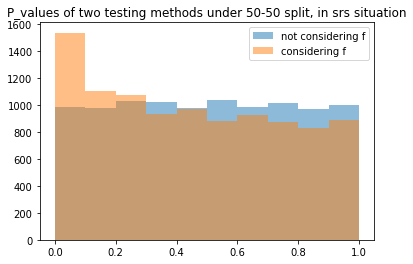

In [289]:
test_result_srs = []
test_result_srswor = []
for i in tqdm(range(10000)):
    # get the sample of experiment
    sample_iter_srs = np.random.choice(population, 5000, replace = True)
    # sample_iter_srswor = np.random.choice(population, 5000, replace = False)
    # get the sample of each experiment version
    con_srs = np.random.choice(population, 2500, replace = True)
    trt_srs = np.random.choice(population, 2500, replace = True)
    # con_srswor, trt_srswor = get_2_bkts(sample_iter_srswor)
    # conduct t-tests
    test_result_srs.append(ttests_sample_ratio(con_srs, trt_srs, f = 0))
    test_result_srswor.append(ttests_sample_ratio(con_srs, trt_srs, f = 0.25))
plt.hist([i[1] for i in test_result_srs], alpha = 0.5)
plt.hist([i[1] for i in test_result_srswor], alpha = 0.5)
plt.legend(['not considering f', 'considering f'])
plt.title('P_values of two testing methods under 50-50 split, in srs situation')

It shows that we should not considering sampling ratio f in __srs scenario__, because p_values of `considering f` is not uniform.

In [264]:
# stats.kstest([i[1] for i in test_result_srs], lambda x: stats.uniform.cdf(x,0,1)),\
# stats.kstest([i[1] for i in test_result_srswor], lambda x: stats.uniform.cdf(x,0,1))

In [265]:
# stats.kstest([i[0] for i in test_result_srs], lambda x: stats.norm.cdf(x, 0,1)),\
# stats.kstest([i[0] for i in test_result_srswor], lambda x: stats.norm.cdf(x, 0,1))

We use srswor to draw 5000 samples from population, and then split into control group(\~2500 samples) and treatment group(\~2500 samples). We perform two sample T-test with/withour considering sampling ratio(f = 0.25).

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'P_values of two testing methods under 50-50 split, in srswor situation')

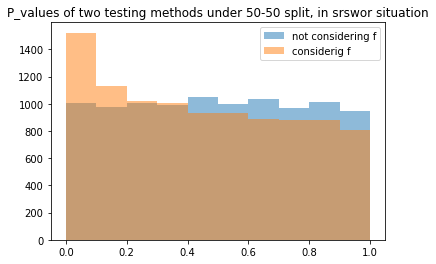

In [290]:
test_result_srs = []
test_result_srswor = []
for i in tqdm(range(10000)):
    # get the sample of experiment
    sample_iter_srswor = np.random.choice(population, 5000, replace = False) # N_population = 10000, n_control + n_treatment = 5000

    # get the sample of each experiment version

    con_srswor, trt_srswor = get_2_bkts(sample_iter_srswor) # n_control/n_treatment = 2500, f = 0.25. This is another srswor
    # conduct t-tests
    test_result_srs.append(ttests_sample_ratio(con_srswor, trt_srswor, f = 0))
    test_result_srswor.append(ttests_sample_ratio(con_srswor, trt_srswor, f = 0.25))

plt.hist([i[1] for i in test_result_srs], alpha = 0.5)
plt.hist([i[1] for i in test_result_srswor], alpha = 0.5)
plt.legend(['not considering f', 'considerig f'])
plt.title('P_values of two testing methods under 50-50 split, in srswor situation')

It shows that we should not considering sampling ratio f in __srswor scenario__, because p_values of `considering f` is not uniform.

# In one sample scenario, we need sampling ratio f to estimate variance of sampling mean.

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'P_values of two testing methods under 50-50 split, in srswor situation')

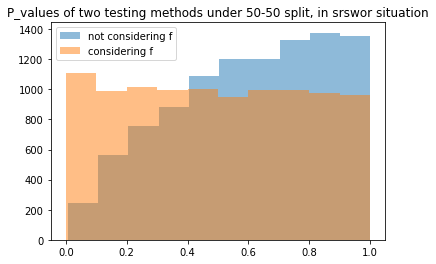

In [328]:
test_result_srs = []
test_result_srswor = []
for i in tqdm(range(10000)):
    # 从10k总体中, 抽取5k个样本. 抽样比f = 0.5
    sample_iter_srswor = np.random.choice(population, 5000, replace = False) 

    # conduct t-tests. 检验样本的均值是否!=10
    ## 计算不考虑抽样比的结果
    t_stats_not_considering_f = (sample_iter_srswor.mean()-10)/np.std(sample_iter_srswor)*np.sqrt(len(sample_iter_srswor))
    p_value_not_considering_f = 2*(1 - norm.cdf(abs(t_stats_not_considering_f)))

    ## 计算考虑抽样比的结果
    f = 0.5
    var = np.var(sample_iter_srswor)/len(sample_iter_srswor)*(1-f) # 带有抽样比
    t_stats_considering_f = (sample_iter_srswor.mean()-10)/var**0.5
    p_value_considering_f = 2*(1 - norm.cdf(abs(t_stats_considering_f))) 
    
    # 输出检验的统计量和p值
    test_result_srs.append((t_stats_not_considering_f, p_value_not_considering_f))
    test_result_srswor.append((t_stats_considering_f, p_value_considering_f))

# 发现考虑抽样比的时候, p值是服从均匀分布的. 所以应该考虑抽样比
plt.hist([i[1] for i in test_result_srs], alpha = 0.5)
plt.hist([i[1] for i in test_result_srswor], alpha = 0.5)
plt.legend(['not considering f', 'considering f'])
plt.title('P_values of two testing methods under 50-50 split, in srswor situation')

In [330]:
np.max(population) - np.min(population),np.max(population1) - np.min(population1),np.max(population2) - np.min(population2)

(14.199575981190197, 15.793071407493063, 14.93495020096293)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'P_values of two testing methods under 50-50 split, in srswor situation')

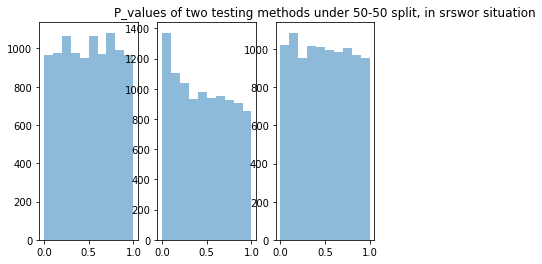

In [340]:
l1 = []
l2 = []
l3 = []

for i in tqdm(range(10000)):
    # 从10k总体中, 抽取5k个样本. 抽样比f = 0.2
    con_srswor = np.random.choice(population1, 2000, replace = False) 
    trt_srswor = np.random.choice(population2, 2000, replace = False) 

    # conduct t-tests. 检验样本的均值是否相等
    ## 计算不考虑抽样比的结果
    l1.append(ttests_sample_ratio(con_srswor, trt_srswor, f = 0))
    l2.append(ttests_sample_ratio(con_srswor, trt_srswor, f = 0.2))

    # 单样本
    data = np.random.choice(population, 2000, replace = False) 
    var = np.var(data)/(len(data)-1)*(1-0.2) # 带有抽样比
    t_stats_considering_f = (data.mean()-10)/var**0.5
    p_value_considering_f = 2*(1 - norm.cdf(abs(t_stats_considering_f))) 
    l3.append((t_stats_considering_f, p_value_considering_f))

# 发现考虑抽样比的时候, p值是服从均匀分布的. 所以应该考虑抽样比
plt.subplot(1,3,1)
plt.hist([i[1] for i in l1], alpha = 0.5)
plt.subplot(1,3,2)
plt.hist([i[1] for i in l2], alpha = 0.5)
plt.subplot(1,3,3)
plt.hist([i[1] for i in l3], alpha = 0.5)
# plt.legend(['not considering f', 'considering f', '1_sample_considering_f'])
plt.title('P_values of two testing methods under 50-50 split, in srswor situation')


即使是从两个总体中分别不放回抽取子样本, 仍然不需要借助抽样比来计算方差, 因为我们可以通过比较子样本的均值差来推断总体的均值差.